In [2]:
import torch
from torch import nn

In [3]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
import requests
import zipfile
from pathlib import Path


# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "in_out_dataset"


In [5]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(WindowsPath('data/in_out_dataset/train'),
 WindowsPath('data/in_out_dataset/test'))

Random image path: data\in_out_dataset\test\move_out\out9.jpg
Image class: move_out
Image height: 119
Image width: 496


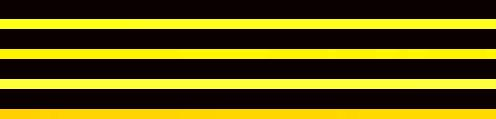

In [6]:
import random
from PIL import Image

# Set seed
random.seed(42) # <- try changing this and see what happens

# 1. Get all image paths (* means "any combination")
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img

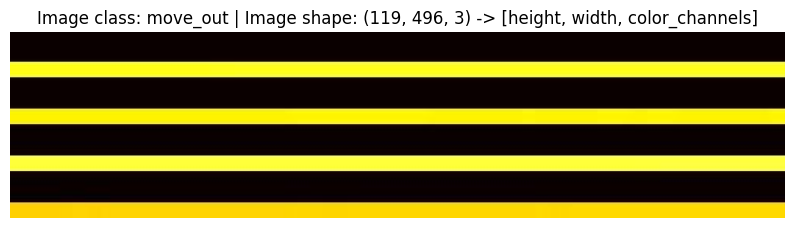

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False)

In [8]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [ ]:
# Write transform for image
data_transform = transforms.Compose([
    # Resize the images to 64x64
    transforms.Resize(size=(12, 50)),
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0 
])

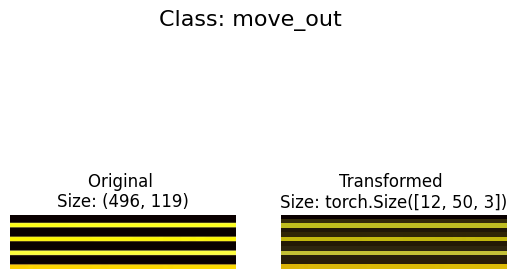

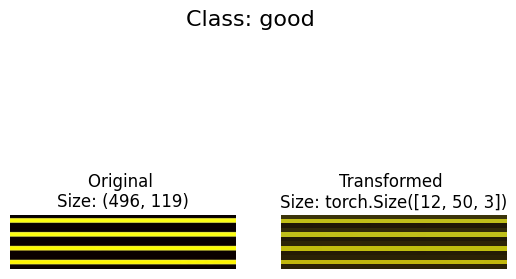

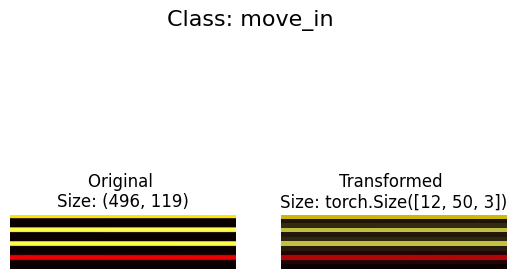

In [10]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths. 
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib 
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list, 
                        transform=data_transform, 
                        n=3)

In [11]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=data_transform, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

test_data = datasets.ImageFolder(root=test_dir, 
                                 transform=data_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 120
    Root location: data\in_out_dataset\train
    StandardTransform
Transform: Compose(
               Resize(size=(12, 50), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 29
    Root location: data\in_out_dataset\test
    StandardTransform
Transform: Compose(
               Resize(size=(12, 50), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )


In [12]:
# Get class names as a list
class_names = train_data.classes
class_names

['good', 'move_in', 'move_out']

In [13]:
# Can also get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'good': 0, 'move_in': 1, 'move_out': 2}

In [14]:
# Check the lengths
len(train_data), len(test_data)

(120, 29)

In [15]:
# Turn train and test Datasets into DataLoaders
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset=train_data, 
                              batch_size=1, # how many samples per batch?
                              num_workers=1, # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True) # shuffle the data?

test_dataloader = DataLoader(dataset=test_data, 
                             batch_size=1, 
                             num_workers=1, 
                             shuffle=False) # don't usually need to shuffle testing data

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x1607eae4850>,
 <torch.utils.data.dataloader.DataLoader at 0x16001092ed0>)

In [16]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 12, 50]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


In [ ]:
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize((12, 50)),
    transforms.Grayscale(num_output_channels=3),  # Convert to grayscale
    transforms.ToTensor() # use ToTensor() last to get everything between 0 & 1
])

# Don't need to perform augmentation on the test data
test_transforms = transforms.Compose([
    transforms.Resize((12, 50)), 
    transforms.ToTensor()
])

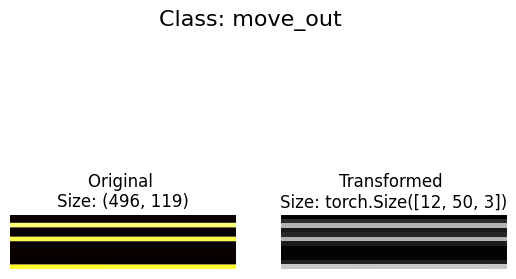

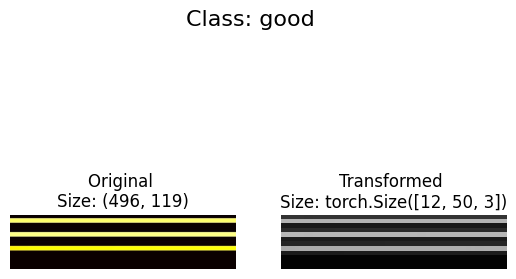

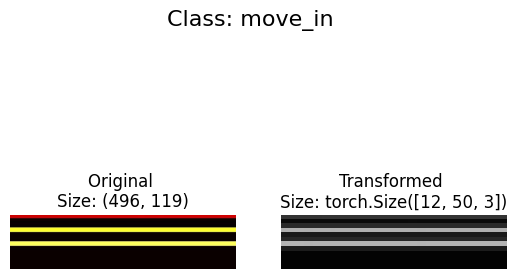

In [18]:
# Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# Plot random images
plot_transformed_images(
    image_paths=image_path_list,
    transform=train_transforms,
    n=3,
    seed=None
)

In [ ]:
# Create simple transform
simple_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert to grayscale 
    transforms.Resize((12, 50)),
    transforms.ToTensor(),
])

In [ ]:
# 1. Load and transform data
from torchvision import datasets
train_data_simple = datasets.ImageFolder(root=train_dir, transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir, transform=simple_transform)

# 2. Turn data into DataLoaders
import os
from torch.utils.data import DataLoader

# Setup batch size and number of workers 
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
print(f"Creating DataLoader's with batch size {BATCH_SIZE} and {NUM_WORKERS} workers.")

# Create DataLoader's
train_dataloader_simple = DataLoader(train_data_simple, 
                                     batch_size=BATCH_SIZE, 
                                     shuffle=True, 
                                     num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(test_data_simple, 
                                    batch_size=BATCH_SIZE, 
                                    shuffle=False, 
                                    num_workers=NUM_WORKERS)

train_dataloader_simple, test_dataloader_simple







Creating DataLoader's with batch size 32 and 8 workers.


(<torch.utils.data.dataloader.DataLoader at 0x16001360850>,
 <torch.utils.data.dataloader.DataLoader at 0x160012c6f50>)

In [21]:
class AppleGrasper(nn.Module):

    def __init__(self, input_shape: int, h1: int, h2: int, h3: int, h4: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=h1, 
                      kernel_size=5, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=2), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=h1, 
                      out_channels=h2, 
                      kernel_size=3, 
                      padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )

        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(in_channels=h2,
                      out_channels=h3,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=h3,
                      out_channels=h4,
                      kernel_size=5,
                      stride=1,
                      padding=2),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # nn.Linear(in_features=8*1*3, 
            nn.Linear(in_features=8*1*6, 
                      out_features=64),
            nn.LeakyReLU(),
            nn.Dropout(p=0.5),
            # Where did this in_features shape come from? 
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=64,
                      out_features=output_shape),
            nn.Softmax(dim=1)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv_block_2(x)
        # print(x.shape)
        x = self.conv_block_3(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x

torch.manual_seed(42)
model_0 = AppleGrasper(input_shape=3, # number of color channels (3 for RGB) 
                  h1=8,
                  h2=16,
                  h3=32, 
                  h4=8,
                  output_shape=len(train_data.classes)).to(device)
model_0

AppleGrasper(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): LeakyReLU(negative_slope=0.01)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(32, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (3): LeakyReLU(negative_slope=0.01)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=48, out_features=64, bias=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3

In [22]:
from torchinfo import summary
summary(model_0, input_size=[1, 3, 12, 50]) # do a test pass through of an example input size 

Layer (type:depth-idx)                   Output Shape              Param #
AppleGrasper                             [1, 3]                    --
├─Sequential: 1-1                        [1, 8, 6, 25]             --
│    └─Conv2d: 2-1                       [1, 8, 12, 50]            608
│    └─LeakyReLU: 2-2                    [1, 8, 12, 50]            --
│    └─MaxPool2d: 2-3                    [1, 8, 6, 25]             --
├─Sequential: 1-2                        [1, 16, 3, 12]            --
│    └─Conv2d: 2-4                       [1, 16, 6, 25]            1,168
│    └─LeakyReLU: 2-5                    [1, 16, 6, 25]            --
│    └─MaxPool2d: 2-6                    [1, 16, 3, 12]            --
├─Sequential: 1-3                        [1, 8, 1, 6]              --
│    └─Conv2d: 2-7                       [1, 32, 3, 12]            4,640
│    └─LeakyReLU: 2-8                    [1, 32, 3, 12]            --
│    └─Conv2d: 2-9                       [1, 8, 3, 12]             6,408
│    

In [23]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()
    
    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [24]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval() 
    
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)
    
            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [25]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    
    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)
        
        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

C:\Users\cbgno\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [27]:
# Set random seeds
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 40

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()


optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001, weight_decay=1e-5)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train model_1
model_1_results = train(model=model_0, 
                        # train_dataloader=train_dataloader_augmented,
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  2%|▎         | 1/40 [00:20<13:24, 20.63s/it]

Epoch: 1 | train_loss: 1.0991 | train_acc: 0.3411 | test_loss: 1.1006 | test_acc: 0.3103


  5%|▌         | 2/40 [00:44<14:16, 22.54s/it]

Epoch: 2 | train_loss: 1.0982 | train_acc: 0.3333 | test_loss: 1.1000 | test_acc: 0.3103


  8%|▊         | 3/40 [01:04<13:02, 21.15s/it]

Epoch: 3 | train_loss: 1.0966 | train_acc: 0.3438 | test_loss: 1.0983 | test_acc: 0.3103


 10%|█         | 4/40 [01:21<11:49, 19.72s/it]

Epoch: 4 | train_loss: 1.0957 | train_acc: 0.4245 | test_loss: 1.0937 | test_acc: 0.5172


 12%|█▎        | 5/40 [01:40<11:18, 19.40s/it]

Epoch: 5 | train_loss: 1.0890 | train_acc: 0.5521 | test_loss: 1.0817 | test_acc: 0.6207


 15%|█▌        | 6/40 [01:59<10:53, 19.22s/it]

Epoch: 6 | train_loss: 1.0736 | train_acc: 0.6302 | test_loss: 1.0541 | test_acc: 0.6207


 18%|█▊        | 7/40 [02:15<09:58, 18.14s/it]

Epoch: 7 | train_loss: 1.0322 | train_acc: 0.6562 | test_loss: 0.9927 | test_acc: 0.6207


 20%|██        | 8/40 [02:35<10:03, 18.87s/it]

Epoch: 8 | train_loss: 0.9627 | train_acc: 0.6719 | test_loss: 0.8733 | test_acc: 0.6897


 22%|██▎       | 9/40 [02:56<10:08, 19.64s/it]

Epoch: 9 | train_loss: 0.8204 | train_acc: 0.8802 | test_loss: 0.7292 | test_acc: 0.9655


 25%|██▌       | 10/40 [03:15<09:36, 19.22s/it]

Epoch: 10 | train_loss: 0.6922 | train_acc: 0.9453 | test_loss: 0.6129 | test_acc: 0.9655


 28%|██▊       | 11/40 [03:29<08:33, 17.71s/it]

Epoch: 11 | train_loss: 0.6117 | train_acc: 0.9844 | test_loss: 0.5830 | test_acc: 0.9655


 30%|███       | 12/40 [03:43<07:47, 16.69s/it]

Epoch: 12 | train_loss: 0.5735 | train_acc: 0.9766 | test_loss: 0.5796 | test_acc: 0.9655


 32%|███▎      | 13/40 [03:58<07:13, 16.04s/it]

Epoch: 13 | train_loss: 0.5622 | train_acc: 0.9922 | test_loss: 0.5760 | test_acc: 0.9655


 35%|███▌      | 14/40 [04:12<06:44, 15.55s/it]

Epoch: 14 | train_loss: 0.5534 | train_acc: 1.0000 | test_loss: 0.5775 | test_acc: 0.9655


 38%|███▊      | 15/40 [04:27<06:21, 15.28s/it]

Epoch: 15 | train_loss: 0.5541 | train_acc: 1.0000 | test_loss: 0.5778 | test_acc: 0.9655


 40%|████      | 16/40 [04:41<05:59, 14.96s/it]

Epoch: 16 | train_loss: 0.5519 | train_acc: 1.0000 | test_loss: 0.5771 | test_acc: 0.9655


 42%|████▎     | 17/40 [04:56<05:40, 14.82s/it]

Epoch: 17 | train_loss: 0.5534 | train_acc: 1.0000 | test_loss: 0.5766 | test_acc: 0.9655


 45%|████▌     | 18/40 [05:10<05:25, 14.81s/it]

Epoch: 18 | train_loss: 0.5517 | train_acc: 1.0000 | test_loss: 0.5771 | test_acc: 0.9655


 48%|████▊     | 19/40 [05:26<05:17, 15.13s/it]

Epoch: 19 | train_loss: 0.5528 | train_acc: 1.0000 | test_loss: 0.5785 | test_acc: 0.9655


 50%|█████     | 20/40 [05:41<04:57, 14.85s/it]

Epoch: 20 | train_loss: 0.5542 | train_acc: 1.0000 | test_loss: 0.5781 | test_acc: 0.9655


 52%|█████▎    | 21/40 [05:55<04:39, 14.72s/it]

Epoch: 21 | train_loss: 0.5535 | train_acc: 1.0000 | test_loss: 0.5597 | test_acc: 1.0000


 55%|█████▌    | 22/40 [06:09<04:22, 14.56s/it]

Epoch: 22 | train_loss: 0.5520 | train_acc: 1.0000 | test_loss: 0.5521 | test_acc: 1.0000


 57%|█████▊    | 23/40 [06:23<04:05, 14.46s/it]

Epoch: 23 | train_loss: 0.5519 | train_acc: 1.0000 | test_loss: 0.5516 | test_acc: 1.0000


 60%|██████    | 24/40 [06:38<03:51, 14.45s/it]

Epoch: 24 | train_loss: 0.5535 | train_acc: 1.0000 | test_loss: 0.5518 | test_acc: 1.0000


 62%|██████▎   | 25/40 [06:52<03:35, 14.40s/it]

Epoch: 25 | train_loss: 0.5518 | train_acc: 1.0000 | test_loss: 0.5525 | test_acc: 1.0000


 65%|██████▌   | 26/40 [07:06<03:21, 14.37s/it]

Epoch: 26 | train_loss: 0.5515 | train_acc: 1.0000 | test_loss: 0.5538 | test_acc: 1.0000


 68%|██████▊   | 27/40 [07:21<03:08, 14.48s/it]

Epoch: 27 | train_loss: 0.5517 | train_acc: 1.0000 | test_loss: 0.5551 | test_acc: 1.0000


 70%|███████   | 28/40 [07:36<02:54, 14.51s/it]

Epoch: 28 | train_loss: 0.5644 | train_acc: 0.9896 | test_loss: 0.5544 | test_acc: 1.0000


 72%|███████▎  | 29/40 [07:50<02:38, 14.45s/it]

Epoch: 29 | train_loss: 0.5517 | train_acc: 1.0000 | test_loss: 0.5522 | test_acc: 1.0000


 75%|███████▌  | 30/40 [08:04<02:23, 14.38s/it]

Epoch: 30 | train_loss: 0.5515 | train_acc: 1.0000 | test_loss: 0.5518 | test_acc: 1.0000


 78%|███████▊  | 31/40 [08:18<02:08, 14.33s/it]

Epoch: 31 | train_loss: 0.5518 | train_acc: 1.0000 | test_loss: 0.5516 | test_acc: 1.0000


 80%|████████  | 32/40 [08:33<01:54, 14.26s/it]

Epoch: 32 | train_loss: 0.5524 | train_acc: 1.0000 | test_loss: 0.5516 | test_acc: 1.0000


 82%|████████▎ | 33/40 [08:47<01:40, 14.34s/it]

Epoch: 33 | train_loss: 0.5534 | train_acc: 1.0000 | test_loss: 0.5516 | test_acc: 1.0000


 85%|████████▌ | 34/40 [09:01<01:25, 14.30s/it]

Epoch: 34 | train_loss: 0.5520 | train_acc: 1.0000 | test_loss: 0.5516 | test_acc: 1.0000


 88%|████████▊ | 35/40 [09:16<01:11, 14.34s/it]

Epoch: 35 | train_loss: 0.5517 | train_acc: 1.0000 | test_loss: 0.5516 | test_acc: 1.0000


 90%|█████████ | 36/40 [09:30<00:57, 14.28s/it]

Epoch: 36 | train_loss: 0.5522 | train_acc: 1.0000 | test_loss: 0.5517 | test_acc: 1.0000


 92%|█████████▎| 37/40 [09:44<00:42, 14.27s/it]

Epoch: 37 | train_loss: 0.5515 | train_acc: 1.0000 | test_loss: 0.5518 | test_acc: 1.0000


 95%|█████████▌| 38/40 [09:58<00:28, 14.22s/it]

Epoch: 38 | train_loss: 0.5528 | train_acc: 1.0000 | test_loss: 0.5521 | test_acc: 1.0000


 98%|█████████▊| 39/40 [10:12<00:14, 14.18s/it]

Epoch: 39 | train_loss: 0.5515 | train_acc: 1.0000 | test_loss: 0.5525 | test_acc: 1.0000


100%|██████████| 40/40 [10:27<00:00, 15.69s/it]

Epoch: 40 | train_loss: 0.5515 | train_acc: 1.0000 | test_loss: 0.5529 | test_acc: 1.0000
Total training time: 627.440 seconds


In [28]:
from typing import Dict, List

def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

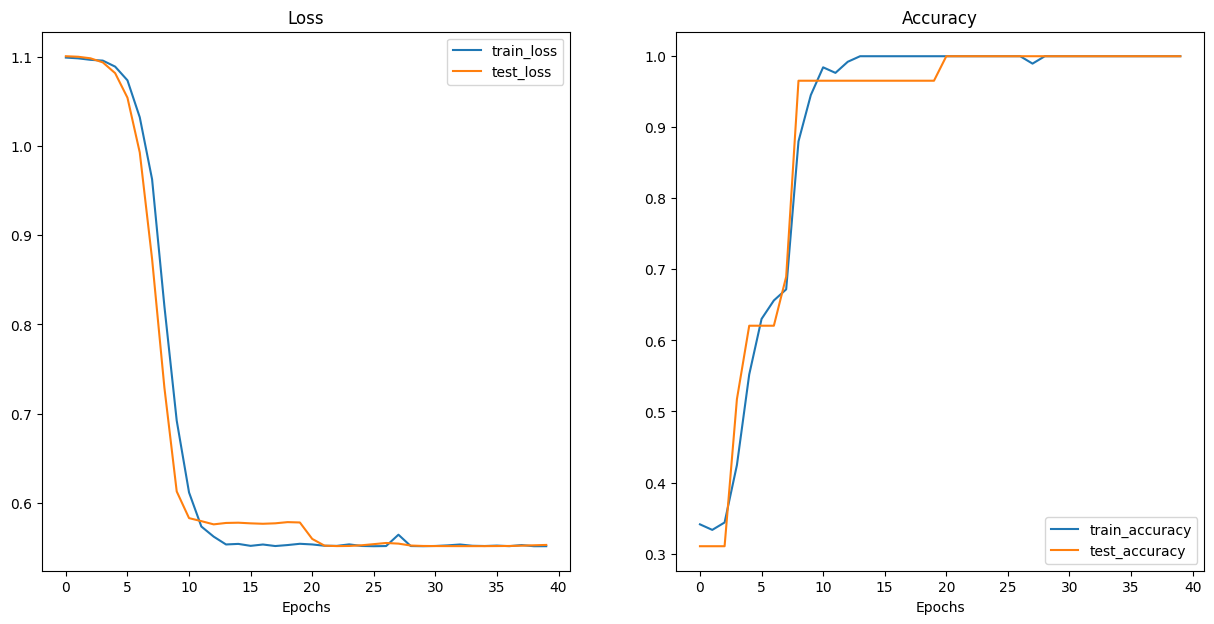

In [29]:
plot_loss_curves(model_1_results)

In [48]:
from pathlib import Path

# Create models directory (if it doesn't already exist), see: https://docs.python.org/3/library/pathlib.html#pathlib.Path.mkdir
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, # create parent directories if needed
                 exist_ok=True # if models directory already exists, don't error
)

# Create model save path
MODEL_NAME = "apple_grasper_model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), # only saving the state_dict() only saves the learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models\apple_grasper_model.pth


In [34]:
# Download custom image
import requests
import torchvision

# Setup custom image path
custom_image_path = data_path / "test_images" / "test.jpg"



# Create transform pipleine to resize image
custom_image_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert to grayscale 
    transforms.Resize((12, 50)),
])


In [46]:
def pred_and_plot_image(model: torch.nn.Module, 
                        image_path: str, 
                        class_names: List[str] = None, 
                        transform=None,
                        device: torch.device = device):
    """Makes a prediction on a target image and plots the image with its prediction."""
    
    # 1. Load in image and convert the tensor values to float32
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)
    
    # 2. Divide the image pixel values by 255 to get them between [0, 1]
    target_image = target_image / 255. 
    
    # 3. Transform if necessary
    if transform:
        target_image = transform(target_image)
    
    # 4. Make sure the model is on the target device
    model.to(device)
    
    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Add an extra dimension to the image
        target_image = target_image.unsqueeze(dim=0)
    
        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(target_image.to(device))
        
    # 6. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)
    print(target_image_pred_probs)

    # 7. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)
    
    # 8. Plot the image alongside the prediction and prediction probability
    plt.imshow(target_image.squeeze().permute(1, 2, 0)) # make sure it's the right size for matplotlib
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else: 
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False);

tensor([[0.5760, 0.2120, 0.2120]])


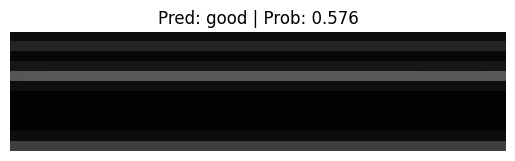

In [47]:
# Pred on our custom image
pred_and_plot_image(model=model_0,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)